In [25]:
import torch
import torchvision
import os
from pathlib import Path

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, RandomSampler, Subset
from torchvision import transforms
from torch.nn import MSELoss
from captum.attr import IntegratedGradients

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from lfxai.models.images import AutoEncoderMnist, EncoderMnist, DecoderMnist
from lfxai.models.pretext import Identity, RandomNoise
from lfxai.explanations.features import attribute_auxiliary
from lfxai.explanations.examples import TracIn, InfluenceFunctions
from lfxai.utils.metrics import (
    compute_metrics,
    cos_saliency,
    count_activated_neurons,
    entropy_saliency,
    pearson_saliency,
    similarity_rates,
    spearman_saliency,
)

In [26]:
# Parameters

random_seed: int = 1
batch_size: int = 200
dim_latent: int = 4
n_epochs: int = 100
subtrain_size: int = 1000

# Initialize seed and device
torch.random.manual_seed(random_seed)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [89]:
# Autoencoder model

# Load MNIST
data_dir = Path.cwd() / "data/mnist"
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset.transform = train_transform
test_dataset.transform = test_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# Initialize encoder, decoder and autoencoder wrapper
pert = RandomNoise()
encoder = EncoderMnist(encoded_space_dim=dim_latent)
decoder = DecoderMnist(encoded_space_dim=dim_latent)
autoencoder = AutoEncoderMnist(encoder, decoder, dim_latent, pert)
encoder.to(device)
decoder.to(device)
autoencoder.to(device)

# Train the denoising autoencoder
save_dir = Path.cwd() / "results/mnist/consistency_examples"
if not save_dir.exists():
    os.makedirs(save_dir)
if not (save_dir / (autoencoder.name + ".pt")).exists():
    autoencoder.fit(
        device, train_loader, test_loader, save_dir, n_epochs, checkpoint_interval=10
    )
else:      
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
autoencoder.train().to(device)

AutoEncoderMnist(
  (encoder): EncoderMnist(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (decoder): DecoderMnist(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim

In [28]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [90]:
# Attributes for Influence Functions (too heavy computationally)

idx_subtrain = [
    torch.nonzero(train_dataset.targets == (n % 10))[n // 10].item()
    for n in range(subtrain_size)
]

idx_subtest = [
    torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
    for n in range(subtrain_size)
]

train_subset = Subset(train_dataset, idx_subtrain)
test_subset = Subset(test_dataset, idx_subtest)
subtrain_loader = DataLoader(train_subset)
subtest_loader = DataLoader(test_subset)
labels_subtrain = torch.cat([label for _, label in subtrain_loader])
labels_subtest = torch.cat([label for _, label in subtest_loader])

In [92]:
autoencoder.test_epoch(device, subtest_loader)

0.027153466

In [ ]:
test2_subset = Subset(test_dataset, idx_subtest)

In [ ]:
from MNISTdataset import CustomMNIST

train_dataset = CustomMNIST(data_dir, train=True, download=True)
test_dataset = CustomMNIST(data_dir, train=False, download=True)

len(train_dataset), len(test_dataset)

(60000, 10000)

In [ ]:
# Create a training set sampler with replacement for computing influence functions
recursion_depth = 100
train_sampler = RandomSampler(
    train_dataset, replacement=True, num_samples=recursion_depth * batch_size
)
train_loader_replacement = DataLoader(
    train_dataset, batch_size, sampler=train_sampler
)

# Fitting explainers, computing the metric and saving everything
mse_loss = torch.nn.MSELoss()
explainer_list = [
    InfluenceFunctions(autoencoder, mse_loss, save_dir / "if_grads"),
]

frac_list = [0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
n_top_list = [int(frac * len(idx_subtrain)) for frac in frac_list]
results_dict = {}
for explainer in explainer_list:
    attribution = explainer.attribute_loader(
        device,
        subtrain_loader,
        subtest_loader,
        train_loader_replacement=train_loader_replacement,
        recursion_depth=recursion_depth,
    )
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
    results_dict[str(explainer)] = attribution

In [30]:
# preparing attributes for TracIn

idx_subtrain = [
    torch.nonzero(train_dataset.targets == (n % 10))[n // 10].item()
    for n in range(subtrain_size)
]

idx_subtest = [
    torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
    for n in range(subtrain_size)
]

train_subset = Subset(train_dataset, idx_subtrain)
test_subset = Subset(test_dataset, idx_subtest)
subtrain_loader = DataLoader(train_subset)
subtest_loader = DataLoader(test_subset)
labels_subtrain = torch.cat([label for _, label in subtrain_loader])
labels_subtest = torch.cat([label for _, label in subtest_loader])

# Create a training set sampler with replacement for computing influence functions
recursion_depth = 100
train_sampler = RandomSampler(
    train_dataset, replacement=True, num_samples=recursion_depth * batch_size
)
train_loader_replacement = DataLoader(
    train_dataset, batch_size, sampler=train_sampler
)

# Fitting explainers, computing the metric and saving everything
mse_loss = torch.nn.MSELoss()
explainer_list = [
    TracIn(autoencoder, mse_loss, save_dir / "tracin_grads")
]

frac_list = [0.05, 0.1, 0.2, 0.5, 0.7, 1.0]
n_top_list = [int(frac * len(idx_subtrain)) for frac in frac_list]

In [31]:
# Creating results dictionary and saving attributions for each explainer
results_dict = {}
for explainer in explainer_list:
    attribution = explainer.attribute_loader(
        device,
        subtrain_loader,
        subtest_loader,
        train_loader_replacement=train_loader_replacement,
        recursion_depth=recursion_depth,
    )
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
    results_dict[str(explainer)] = attribution

In [32]:
# Open results dictionary
save_dir = Path.cwd() / "results/mnist/consistency_examples"

with open(save_dir / "results_dict.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [33]:
results_dict['TracIn'].shape   

results_list = []

for explainer in results_dict.keys():
    attribution = results_dict[explainer]
    sim_most, sim_least = similarity_rates(
        attribution, labels_subtrain, labels_subtest, n_top_list
    )
    results_list += [
        [str(explainer), "Most Important", 100 * frac, sim]
        for frac, sim in zip(frac_list, sim_most)
    ]
    results_list += [
        [str(explainer), "Least Important", 100 * frac, sim]
        for frac, sim in zip(frac_list, sim_least)
    ]
    results_df = pd.DataFrame(
    results_list,
    columns=[
        "Explainer",
        "Type of Examples",
        "% Examples Selected",
        "Similarity Rate",
    ],
    )
    

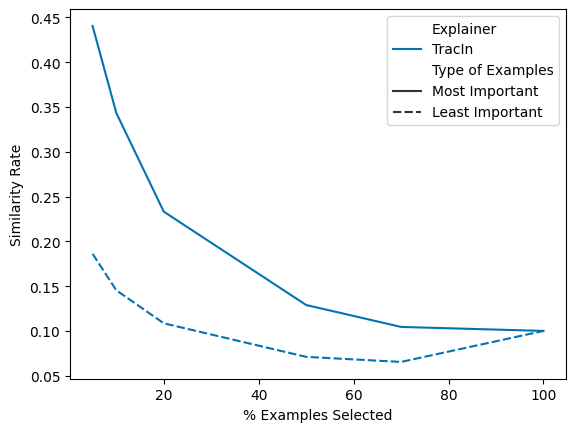

In [34]:
# Checking that results are consistent with paper 
results_df.to_csv(save_dir / "metrics.csv")
sns.lineplot(
data=results_df,
x="% Examples Selected",
y="Similarity Rate",
hue="Explainer",
style="Type of Examples",
palette="colorblind",
)
plt.savefig(save_dir / "similarity_rates.pdf")

# NEW: removing oponents

In [83]:
oponents_index = (results_dict['TracIn'].mean(axis=0) < 0).nonzero().flatten()
oponents_index.shape

torch.Size([193])

In [84]:
print(oponents_index)

tensor([  0,   4,   6,  20,  24,  32,  33,  38,  43,  44,  64,  84,  94,  99,
        102, 108, 124, 136, 138, 144, 154, 163, 164, 165, 166, 167, 173, 174,
        180, 183, 193, 198, 204, 212, 213, 223, 226, 228, 235, 238, 240, 245,
        253, 254, 262, 263, 269, 270, 272, 288, 292, 294, 299, 313, 318, 322,
        332, 338, 340, 349, 354, 358, 369, 373, 378, 384, 403, 405, 408, 413,
        415, 416, 423, 424, 429, 430, 433, 444, 445, 453, 462, 463, 467, 473,
        475, 477, 482, 485, 488, 490, 492, 499, 500, 502, 503, 507, 508, 518,
        524, 532, 535, 543, 545, 553, 554, 557, 563, 569, 582, 583, 584, 586,
        592, 600, 608, 610, 624, 625, 633, 642, 648, 649, 650, 654, 658, 663,
        670, 678, 680, 682, 686, 688, 689, 694, 699, 703, 718, 722, 728, 729,
        730, 732, 740, 748, 749, 757, 758, 760, 762, 764, 772, 778, 784, 799,
        809, 810, 812, 814, 815, 819, 820, 834, 840, 858, 860, 863, 868, 870,
        880, 886, 889, 890, 892, 894, 913, 914, 920, 930, 933, 9

In [85]:
for i in range(193):
    print(idx_subtrain[oponents_index[i]])

1
2
13
34
20
28
27
46
30
53
60
64
89
80
143
144
127
129
188
139
142
149
150
244
155
158
157
163
156
179
181
265
194
220
203
207
238
312
306
333
216
316
235
271
268
242
264
234
277
386
317
292
282
281
415
339
347
439
303
322
338
456
344
341
485
363
392
504
517
405
512
465
425
379
383
451
433
402
516
459
448
479
446
486
543
467
472
544
594
489
476
434
519
477
500
483
615
627
531
530
620
549
622
557
569
521
561
520
563
581
590
658
568
633
734
639
647
719
659
619
758
595
667
663
761
695
669
769
689
657
759
777
626
692
631
760
792
684
796
704
743
688
745
823
727
703
831
781
713
742
714
865
749
764
772
849
801
804
912
782
859
834
869
972
889
909
976
903
927
958
826
943
863
855
992
882
957
965
1007
979
929
984
1062
930
997
1067
1015
1077
1101
1010
1097
1104
1105


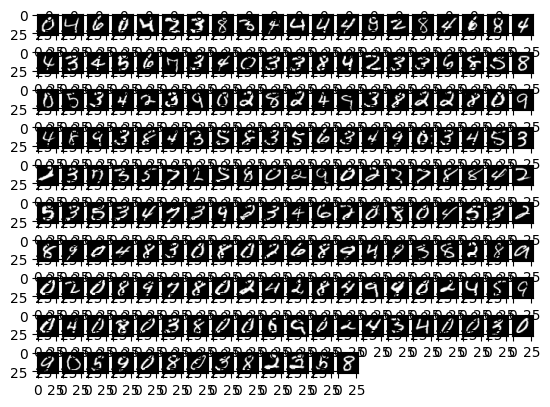

In [43]:
for i in range(193):
    # plot training samples
    plt.subplot(10, 20, i + 1)
    plt.imshow(train_dataset.data[idx_subtrain[oponents_index[i]]], cmap="gray")

In [81]:
torch.save(oponents_index, save_dir / "oponents_index.pt")

# Retraining model without oponents

In [76]:
from MNISTdataset import CustomMNIST

train_dataset = CustomMNIST(data_dir, train=True, download=True)
test_dataset = CustomMNIST(data_dir, train=False, download=True)

len(train_dataset), len(test_dataset)

(60000, 10000)

In [77]:
# store idx_subtrain in oponents_index

idx_oponents = []
for i in range(193):
    idx_oponents.append(idx_subtrain[oponents_index[i]])

In [82]:
torch.save(idx_oponents, save_dir / "oponents_index.pt")

In [79]:
# remove the 193 oponents from the training set
for i in idx_oponents:
    train_dataset.remove_example(i)

In [80]:
len(train_dataset)

59807

In [95]:
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_dataset.transform = train_transform
test_dataset.transform = test_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# Initialize encoder, decoder and autoencoder wrapper
pert = RandomNoise()
encoder = EncoderMnist(encoded_space_dim=dim_latent)
decoder = DecoderMnist(encoded_space_dim=dim_latent)
autoencoder = AutoEncoderMnist(encoder, decoder, dim_latent, pert)
encoder.to(device)
decoder.to(device)
autoencoder.to(device)

# Train the denoising autoencoder
save_dir = Path.cwd() / "results/mnist/proponents_examples"
if not save_dir.exists():
    os.makedirs(save_dir)
if not (save_dir / (autoencoder.name + ".pt")).exists():
    autoencoder.fit(
        device, train_loader, test_loader, save_dir, n_epochs, checkpoint_interval=10
    )
else:      
    autoencoder.load_state_dict(
        torch.load(save_dir / (autoencoder.name + ".pt")), strict=False
    )
autoencoder.train().to(device)

AutoEncoderMnist(
  (encoder): EncoderMnist(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (6): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (decoder): DecoderMnist(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim

In [98]:
autoencoder.test_epoch(device, subtest_loader)

0.026708482